In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import metrics
pd.set_option('display.max_columns', None)

# Importation des datasets

In [2]:
# Créer un chemin d'accès du dossier Train de Data de Alien vs. Predator
import pathlib

#chemin_train = "C:\\Users\\Utilisateur\\Documents\\Projets\\17_RéseauNeuronesConvolution\\Alien vs. Predator"
train_data_dir = pathlib.Path("Data\Train")
train_ds = tf.keras.utils.image_dataset_from_directory(train_data_dir, seed=123, image_size=(150, 150), batch_size=494)

Found 494 files belonging to 2 classes.


In [3]:
test_data_dir = pathlib.Path("Data\Test")
test_ds = tf.keras.utils.image_dataset_from_directory(test_data_dir, seed=123, image_size=(150, 150), batch_size=200)

Found 200 files belonging to 2 classes.


In [4]:
valid_data_dir = pathlib.Path("Data\Validation")
valid_ds = tf.keras.utils.image_dataset_from_directory(valid_data_dir, seed=123, image_size=(150, 150), batch_size=200)

Found 200 files belonging to 2 classes.


# Conversion arrays numpy

## Conversion X_train y_train

In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

X_train = np.array(image_batch)
y_train = np.array(labels_batch)

(494, 150, 150, 3)
(494,)


## Conversion X_valid y_valid

In [6]:
for image_valid_batch, labels_valid_batch in valid_ds:
  print(image_valid_batch.shape)
  print(labels_valid_batch.shape)
  break

X_valid = np.array(image_valid_batch)
y_valid = np.array(labels_valid_batch)

(200, 150, 150, 3)
(200,)


## Conversion X_test y_test

In [7]:
for image_test_batch, labels_test_batch in test_ds:
  print(image_test_batch.shape)
  print(labels_test_batch.shape)
  break

X_test = np.array(image_test_batch)
y_test = np.array(labels_test_batch)

(200, 150, 150, 3)
(200,)


# preprocess_input()

In [8]:
from tensorflow.keras.applications.vgg16 import preprocess_input

train_ds = preprocess_input(X_train)
valid_ds = preprocess_input(X_valid)
test_ds = preprocess_input(X_test)

# VGG 16 : "Transforme les images en caractéristiques"

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16

model_base = VGG16(include_top=False,
    weights="imagenet", #'imagenet' ou path to the weights file to be loaded ?
    input_tensor=None,
    input_shape=None
    )

# Freezer les couches du VGG16: https://datascientest.com/quest-ce-que-le-modele-vgg; https://datacorner.fr/vgg-transfer-learning/
#for layer in model_base.layers:
#    layer.trainable = False

In [10]:
# nouvelles variables de "caractéristiques" de chaque jeu
features_train = model_base.predict(train_ds)
features_valid = model_base.predict(valid_ds)
features_test = model_base.predict(test_ds)

7/7 [==============================] - 11s 2s/step


In [11]:
features_train.shape # vecteur en 4D

(494, 4, 4, 512)

In [12]:
# transformation en vecteurs 2D : (nbre_features, 4*4*512)
features_train_flatten = np.reshape(features_train, (494, 8192))
features_valid_flatten = np.reshape(features_valid, (200, 8192))
features_test_flatten = np.reshape(features_test, (200, 8192))

# Définir le modèle

In [13]:
# d'où "models.Sequential()" et non "Sequential" (?)
# modèle: https://datascientest.com/quest-ce-que-le-modele-vgg
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
#model.add(model_base) # Enlève modèle VGG16 car pas besoin de le faire : fait avec .predict
#model.add(Flatten()) # transforme un tenseur de n dimensions en 2D: on enlève ici car features_flatten + haut
model.add(layers.Dense(units=256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dense(units=1, activation='sigmoid'))

# Définir l'optimiseur et les métriques

In [14]:
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import binary_crossentropy
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

# Entrainement du modèle

In [15]:
nb_batch = 494 # full batch

# Entrainement avec full batch, 500 epoch
history = model.fit(features_train_flatten, y_train,
    validation_data=(features_valid_flatten, y_valid),
    batch_size=nb_batch,
    epochs=100,
    verbose=0
)

# Courbes d'accuracy et de loss

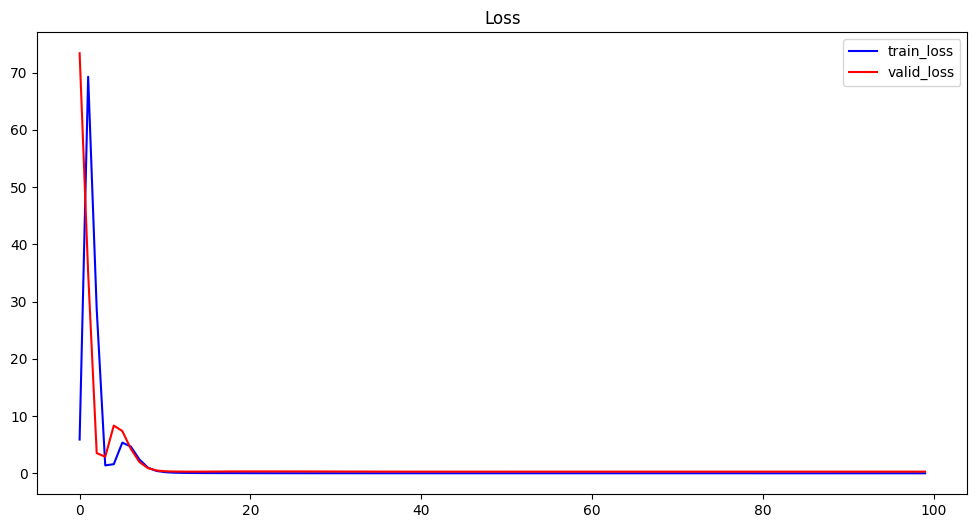

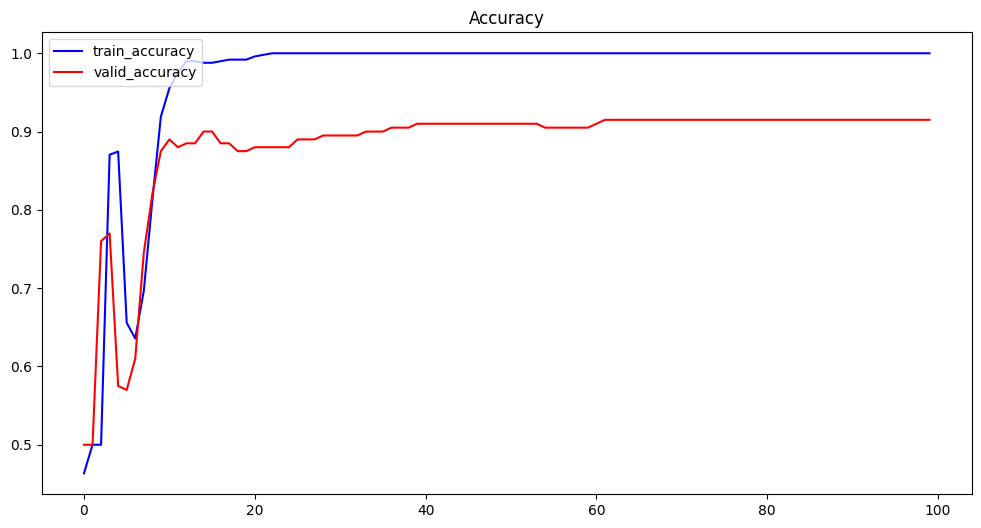

In [16]:
# Loss
plt.subplots(figsize=(12,6))
plt.title("Loss")
plt.plot(history.history['loss'], color='b', label='train_loss')
plt.plot(history.history['val_loss'], color='r', label='valid_loss')
plt.legend(loc='upper right')
# plt.ylim(0.0, 1.0)
plt.show()

# Accuracy
plt.subplots(figsize=(12,6))
plt.title("Accuracy")
plt.plot(history.history['accuracy'], color='b', label='train_accuracy')
plt.plot(history.history['val_accuracy'], color='r', label='valid_accuracy')
plt.legend(loc='upper left')
plt.show()

# Evaluation - jeu de train

In [17]:
# Evaluation du modèle - jeu de train
loss_train, accuracy_train = model.evaluate(features_train_flatten, y_train)
print("Accuracy pour le jeu de train", accuracy_train)
print("Cross-entropie binaire pour le jeu de train", loss_train)

16/16 [==============================] - 0s 3ms/step - loss: 4.5237e-04 - accuracy: 1.0000
Accuracy pour le jeu de train 1.0
Cross-entropie binaire pour le jeu de train 0.000452374602900818


In [18]:
# Prédictions - jeu de validation
ypred_train = model.predict(features_train_flatten, batch_size=nb_batch, verbose=0)

In [19]:
ypred_trainclass = (ypred_train > 0.5).astype(int)

In [20]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, ypred_trainclass)

array([[247,   0],
       [  0, 247]], dtype=int64)

## Evaluation des performances - jeu de validation

In [21]:
# Evaluation du modèle - jeu de validation
loss_valid, accuracy_valid = model.evaluate(features_valid_flatten,y_valid)
print("Accuracy pour le jeu de train", accuracy_valid)
print("Cross-entropie binaire pour le jeu de train", loss_valid)

7/7 [==============================] - 0s 3ms/step - loss: 0.2905 - accuracy: 0.9150
Accuracy pour le jeu de train 0.9150000214576721
Cross-entropie binaire pour le jeu de train 0.29049816727638245


In [22]:
# Prédictions - jeu de validation
ypred_valid = model.predict(features_valid_flatten)

7/7 [==============================] - 0s 3ms/step


In [23]:
ypred_validclass = (ypred_valid > 0.5).astype(int)

In [24]:
confusion_matrix(y_valid, ypred_validclass)

array([[87, 13],
       [ 4, 96]], dtype=int64)

## Evaluation des performances - jeu de validation

In [25]:
# Evaluation du modèle - jeu de test
loss_test, accuracy_test = model.evaluate(features_test_flatten,y_test)
print("Accuracy pour le jeu de train", accuracy_test)
print("Cross-entropie binaire pour le jeu de train", loss_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.2927 - accuracy: 0.9000
Accuracy pour le jeu de train 0.8999999761581421
Cross-entropie binaire pour le jeu de train 0.29269474744796753


In [26]:
# Prédictions - jeu de test
ypred_test = model.predict(features_test_flatten)

7/7 [==============================] - 0s 3ms/step


In [27]:
ypred_testclass = (ypred_test > 0.5).astype(int)

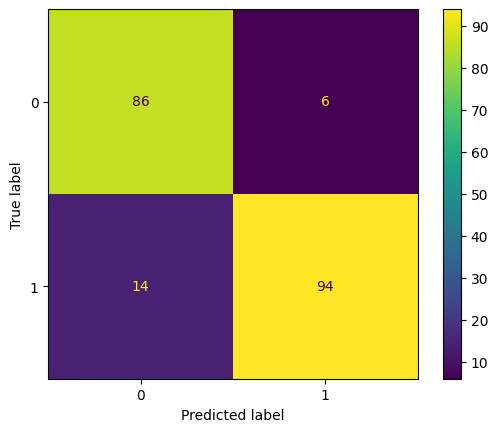

In [28]:
# Matrice de confusion
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(ypred_testclass, y_test)